In [1]:
%load_ext cython
import pyrost as rst
from pyrost.bin import *
from pyrost import simulation as st_sim
import h5py
import os
import numpy as np
import pickle
import pyximport
import sys
import configparser
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from multiprocessing import cpu_count
from scipy.ndimage import gaussian_filter, uniform_filter, convolve1d
from importlib import reload

pyximport.install(reload_support=True, build_in_temp=False)

(None, <pyximport.pyximport.PyxImporter at 0x7fdcd0396510>)

In [2]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'fft_python', 'gaussian_filter', 'ifft_python', 'irfft_python', 'least_squares', 'make_reference', 'mse_total', 'np', 'phase_fit', 'pixel_translations', 'rfft_python', 'st', 'st_update', 'str_update', 'update_pixel_map_gs']


# ST Simulation

In [7]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, p0 = 5e4, th_s=8e-5, n_frames=200,
                           offset=2.0, step_size=0.1, focus=1500, defocus=200,
                           alpha=0.05, ab_cnt=0.7, rnd_dev=0.7, ap_x=10, det_dist=2e6)

globals().update(**params.export_dict())
print(params)

{'defocus': 200.0, 'det_dist': 2000000.0, 'step_size': 0.1, 'n_frames': 200, 'fs_size': 2000, 'ss_size': 1000, 'pix_size': 55.0, 'p0': 50000.0, 'wl': 7.29e-05, 'th_s': 8e-05, 'ap_x': 10.0, 'ap_y': 2.0, 'focus': 1500.0, 'alpha': 0.05, 'ab_cnt': 0.7, 'bar_size': 0.7, 'bar_sigma': 0.18, 'bar_atn': 0.22, 'bulk_atn': 0.15, 'rnd_dev': 0.7, 'offset': 2.0, 'verbose': True}


In [4]:
%time sim_obj = st_sim.STSim(params)

CPU times: user 2min 25s, sys: 8.34 s, total: 2min 33s
Wall time: 17.1 s


In [8]:
%time sim_obj = st_sim.STSim(params)
sim_obj = sim_obj.update_bar_positions(0.7 * np.arange(10))
print(sim_obj.b_steps)

CPU times: user 2.35 s, sys: 388 ms, total: 2.74 s
Wall time: 280 ms
[0.  0.7 1.4 2.1 2.8 3.5 4.2 4.9 5.6 6.3]


In [ ]:
n_x, n_y = params.wavefront_sizes()
nx_arr = np.arange(-n_x // 2, n_x // 2)
ny_arr = np.arange(-n_y // 2, n_y // 2)
lens_wfx, lens_wfy, dx0, dy0 = params.lens_wavefronts(n_y=n_y, return_dxdy=True)
print(n_x, n_y)

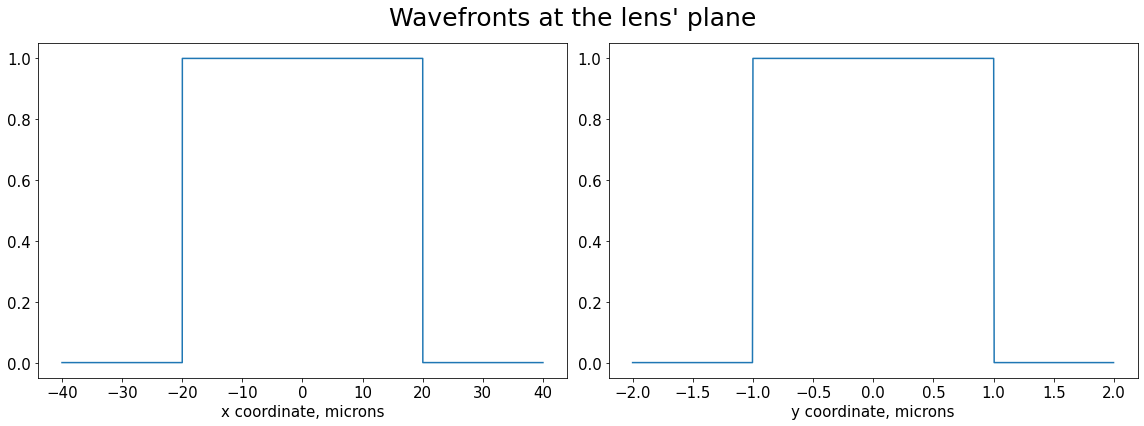

In [37]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx0 * nx_arr, np.abs(lens_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy0 * ny_arr, np.abs(lens_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the lens' plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/lens_wf.pdf')

In [38]:
dx1, dy1 = dx0 * defocus / focus, dy0
z01 = focus + defocus
defoc_wfx = dev.rsc_wp(lens_wfx, dx0, dx1, z01, wl)
defoc_wfy = dev.rsc_wp(lens_wfy, dy0, dy1, z01, wl)

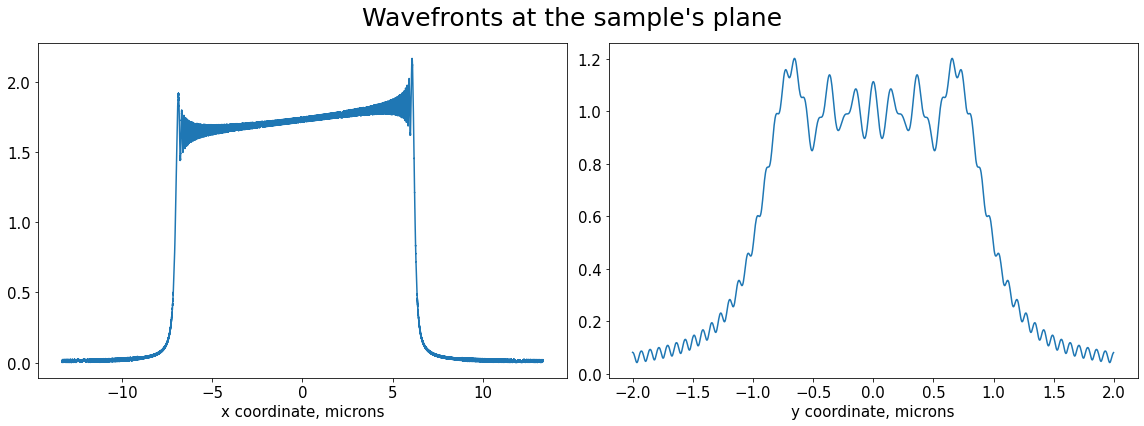

In [39]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx1 * nx_arr, np.abs(defoc_wfx))
axes[0].set_xlabel('x coordinate, microns', fontsize=15)
axes[1].plot(dy1 * ny_arr, np.abs(defoc_wfy))
axes[1].set_xlabel('y coordinate, microns', fontsize=15)
fig.suptitle("Wavefronts at the sample's plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/sample_wf.pdf')

In [40]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'barcode_steps', 'fft_convolve', 'fft_convolve_scan', 'fft_python', 'fhf_wp', 'fhf_wp_scan', 'gaussian_filter', 'ifft_python', 'irfft_python', 'least_squares', 'make_frames', 'np', 'rfft_python', 'rsc_wp', 'rsc_wp_scan']


In [41]:
x0, x1 = params.beam_span(defocus)
x1 += step_size * n_frames
b_steps = dev.barcode_steps(x0, x1, bar_size, rnd_dev)
print(b_steps, x0, x1)

[-6.22061265 -5.42792701 -4.99584105 -4.22803422 -3.58834783 -2.59238181
 -1.9036403  -1.4711028  -0.84456696 -0.02650109  0.69587265  1.35051616
  2.27887654  2.73599866  3.53442099  4.18746446  4.69554574  5.78979684
  6.04507476  6.80236389  7.88479476  8.43835922  8.80823308  9.90628115
 10.19394134 10.88039159 11.58333023 12.79696005 13.37603939 13.69447871
 14.46911389 15.33523114 15.82497744 16.47394634] -6.3576120504496245 16.976516569163195


In [63]:
b_tr = params.barcode_profile(b_steps, dx1, n_x)
sample_wfx = defoc_wfx * b_tr
print(b_tr.shape, sample_wfx.shape, defoc_wfx.shape)

(100, 58527) (100, 58527) (58527,)


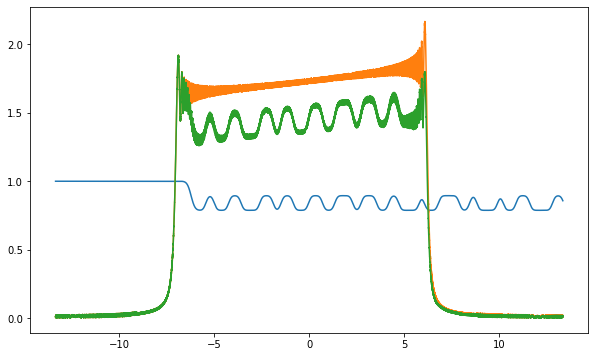

In [43]:
%matplotlib inline
fi = 0
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dx1 * nx_arr, b_tr[0])
ax.plot(dx1 * nx_arr, np.abs(defoc_wfx))
ax.plot(dx1 * nx_arr, np.abs(sample_wfx[0]))
plt.show()

In [44]:
dx2, dy2 = fs_size * pix_size / n_x, ss_size * pix_size / n_y
%time det_wfx = dev.fhf_wp_scan(sample_wfx, dx1, dx2, det_dist, wl)
%time det_wfy = dev.fhf_wp(defoc_wfy, dy1, dy2, det_dist, wl)
print(sample_wfx.shape, det_wfx.shape)

CPU times: user 5.96 s, sys: 252 ms, total: 6.21 s
Wall time: 685 ms
CPU times: user 2.94 ms, sys: 536 µs, total: 3.47 ms
Wall time: 513 µs
(100, 58527) (100, 58527)


In [57]:
2 * ss_size * pix_size * ap_y / wl / det_dist

(3017.8326474622772, 120713.30589849109)

In [61]:
2 * fs_size * pix_size * ap_x * defocus / focus / wl / det_dist

40237.76863283037

In [49]:
dx2 * dx1 / wl / det_dist * n_x, 

(0.6875077935453785, 3.017832647462277)

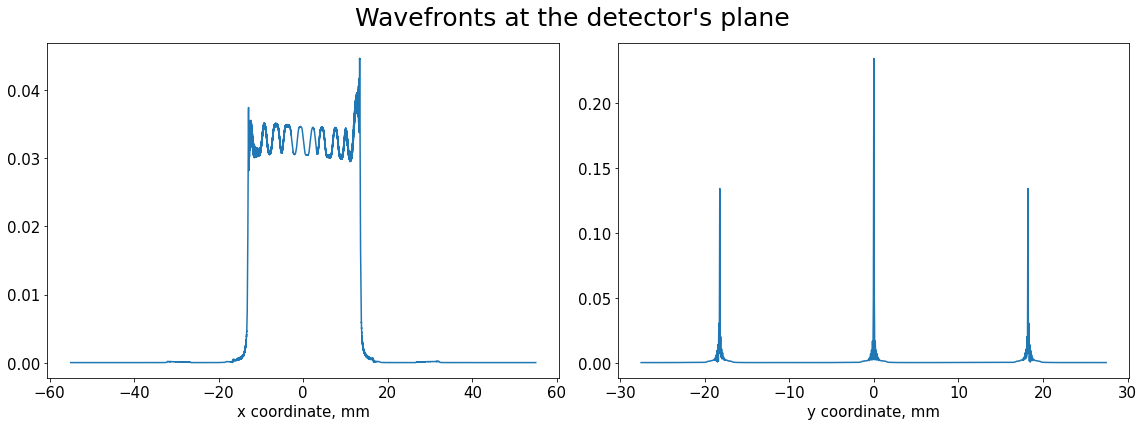

In [45]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.abs(det_wfx[0]))
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.abs(det_wfy))
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector's plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_wf.pdf')

In [31]:
from scipy.signal import fftconvolve

sc_x = params.source_curve(defocus + det_dist, dx2)
sc_y = params.source_curve(defocus + det_dist, dy2)
%time det_ix = dev.fft_convolve_scan(np.abs(det_wfx)**2, sc_x)
%time det_iy = dev.fft_convolve(np.abs(det_wfy)**2, sc_y)
print(det_ix.shape, det_iy.shape)

CPU times: user 539 ms, sys: 98.9 ms, total: 638 ms
Wall time: 107 ms
CPU times: user 3.3 ms, sys: 652 µs, total: 3.95 ms
Wall time: 475 µs
(100, 58527) (1000,)


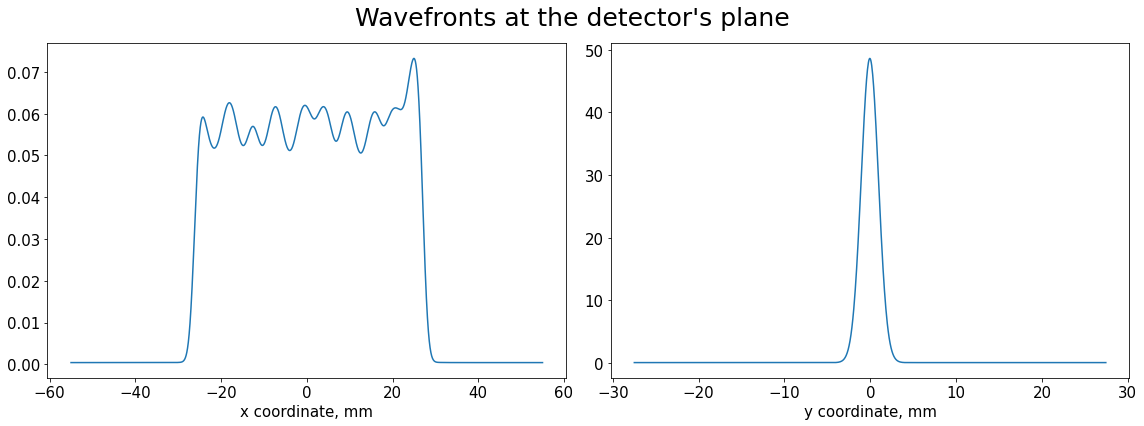

In [32]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(dx2 * nx_arr * 1e-3, np.sqrt(p0) / ap_x * det_ix[0] * dx2)
axes[0].set_xlabel('x coordinate, mm', fontsize=15)
axes[1].plot(dy2 * ny_arr * 1e-3, np.sqrt(p0) / ap_y * det_iy * dy2)
axes[1].set_xlabel('y coordinate, mm', fontsize=15)
fig.suptitle("Wavefronts at the detector's plane", fontsize=25)
for ax in axes:
    ax.tick_params(labelsize=15)
fig.tight_layout()
plt.show()
# plt.savefig('figures/det_int.pdf')

In [24]:
%time frames = dev.make_frames(np.sqrt(p0) / ap_x * det_ix, np.sqrt(p0) / ap_y * det_iy, \
                               dx2, dy2, ss_size, fs_size, False)

CPU times: user 2.19 s, sys: 1.5 s, total: 3.69 s
Wall time: 387 ms


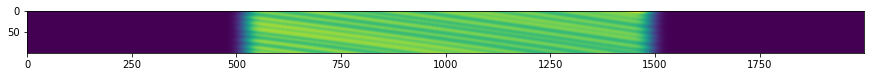

In [25]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 6))
ax.imshow(frames.sum(axis=1))
plt.show()

In [19]:
dir_path = 'results/test'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=True)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

In [20]:
dir_path = 'results/test_ideal'
os.makedirs(dir_path, exist_ok=True)

data = dev.make_frames(i_x=i0 * np.abs(wf1_x * det_c)**2, i_y=(np.abs(wf1_y)**2).sum() * np.ones(1),
                       sc_x=s_arr, sc_y=np.ones(1), pix_size=pix_size, noise=False)

st_params = st_sim.STParams.import_dict(**globals())
ini_parser = st_params.export_ini()
with open(os.path.join(dir_path, 'parameters.ini'), 'w') as file:
    ini_parser.write(file)
    
st_converter = st_sim.STConverter()
st_converter.save(data, st_params, dir_path, roi=roi)

# Prototyping

In [9]:
x_arr = np.linspace(-0.75, 0.75, 512)[:, None]
y_arr = np.linspace(-1.5, 1.5, 512)[None, :]
z_arr = 0.3 * x_arr + np.exp(-6 * x_arr**2 - 6 * (y_arr - 0.7)**2) - \
        np.exp(-3 * x_arr**2 - 6 * (y_arr + 0.7)**2)
z_pad = np.pad(z_arr, ((0, 0), (z_arr.shape[1], 0)), mode='symmetric')
z_pad = np.pad(z_pad, ((z_arr.shape[0], 0), (0, 0)), mode='symmetric')
sx_arr = np.gradient(z_arr, axis=0)
sy_arr = np.gradient(z_arr, axis=1)

In [12]:
u = rst_res.pixel_map
u0 = rst_obj.pixel_map
sx_arr = ((u - u0)[0] - (u - u0)[0].mean())
sy_arr = ((u - u0)[1] - (u - u0)[1].mean())

%time phase_st = ct_integrate(sx_arr, sy_arr)
%time phase_cti = dev.ct_integrate(sx_arr, sy_arr)
print(phase_st.min(), phase_st.max())
print(phase_cti.min(), phase_cti.max())

CPU times: user 773 ms, sys: 8.67 ms, total: 782 ms
Wall time: 783 ms
CPU times: user 66.2 ms, sys: 1.97 ms, total: 68.2 ms
Wall time: 67.6 ms
-434.10308929864084 184.96397905494402
-434.1030892986407 184.96397905494402


In [13]:
error_cti = np.mean((np.gradient(phase_cti, axis=0) - sx_arr)**2 + (np.gradient(phase_cti, axis=1) - sy_arr)**2)
error_st = np.mean((np.gradient(phase_st, axis=0) - sx_arr)**2 + (np.gradient(phase_st, axis=1) - sy_arr)**2)
print(error_cti, error_st)

0.8807470561880254 0.8807470561880257


In [15]:
if sys.modules.get('dev'): # Maybe sys.modules is better?
    dev = sys.modules.get('dev')
    dev = reload(dev)
else:
    import dev
print(dir(dev))

['__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__pyx_unpickle_Enum', '__spec__', '__test__', 'ab_errors', 'ab_model', 'gaussian_filter', 'krig_data', 'least_squares', 'make_frames', 'make_reference', 'mse_frame', 'mse_total', 'np', 'ph_errors', 'ph_model', 'phase_fit', 'pixel_translations', 'st', 'st_update', 'str_update', 'update_pixel_map_gs', 'update_translations_gs', 'upm_surface', 'ut_surface']


In [73]:
dir_path = 'results/test_ideal'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

rst_data = loader.load(os.path.join(dir_path, 'data.cxi'), roi=[0, 1, 610, 1360])
rst_data = rst_data.make_whitefield()
rst_data = rst_data.make_pixel_map()
rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update(sw_fs=10, ls_pm=3., ls_ri=10., verbose=True, n_iter=10)

rst_data.update_phase(rst_res)
fit = rst_data.fit_phase()
fit['ph_fit'][0] * 1e-9

Iteration No. 0: Total MSE = 0.122
Iteration No. 1: Total MSE = 0.078
Iteration No. 2: Total MSE = 0.048
Iteration No. 3: Total MSE = 0.035
Iteration No. 4: Total MSE = 0.030
Iteration No. 5: Total MSE = 0.029
Iteration No. 6: Total MSE = 0.029
Iteration No. 7: Total MSE = 0.029


-0.052319125573869196

In [75]:
dir_path = 'results/test'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

rst_data = loader.load(os.path.join(dir_path, 'data.cxi'), roi=[0, 1, 615, 1375])
rst_data = rst_data.make_whitefield()
rst_data = rst_data.make_pixel_map()
rst_obj = rst_data.get_st()
rst_res, errors = rst_obj.iter_update(sw_fs=10, ls_pm=2, ls_ri=10, verbose=True, n_iter=10)

rst_data.update_phase(rst_res)
fit = rst_data.fit_phase()
fit['ph_fit'][0] * 1e-9

Iteration No. 0: Total MSE = 0.153
Iteration No. 1: Total MSE = 0.108
Iteration No. 2: Total MSE = 0.076
Iteration No. 3: Total MSE = 0.060
Iteration No. 4: Total MSE = 0.053
Iteration No. 5: Total MSE = 0.050
Iteration No. 6: Total MSE = 0.050
Iteration No. 7: Total MSE = 0.050


-0.05211862703789649

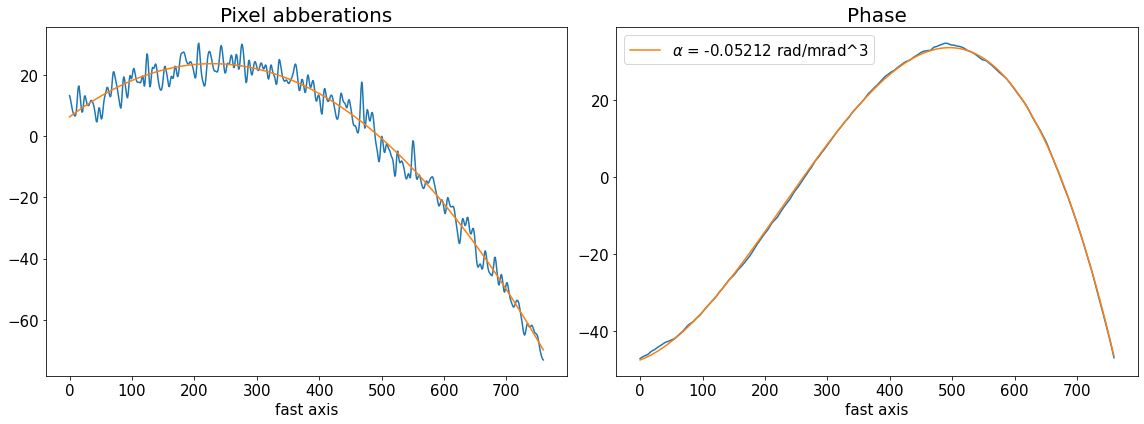

In [76]:
%matplotlib inline
fit_obj = rst_data.get_fit(axis=1)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(fit_obj.pixels, fit_obj.pixel_abberations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('two theta', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/1d_sim_fits.png')

In [6]:
dir_path = 'results/sim_results'
protocol = rst.Protocol.import_ini(os.path.join(dir_path, 'protocol.ini'))
loader = rst.STLoader(protocol=protocol)

rst_data = loader.load(os.path.join(dir_path, 'data.cxi'), roi=(0, 1, 520, 1450))
rst_data = rst_data.make_whitefield()
rst_data = rst_data.make_pixel_map()
dfs_pix = rst_data.get('pixel_translations')[:, 1]

In [44]:
ls_ri = 6

rst_obj = rst_data.get_st()
dj = 200 * (np.random.rand(*rst_obj.dfs_pix.shape) - 0.5)
rst_obj.dfs_pix = dj + dfs_pix
rst_res, errors = rst_obj.iter_update(sw_fs=10, ls_pm=1.5, ls_ri=ls_ri, verbose=False,
                                      update_translations=True, n_iter=15)

rst_data.update_phase(rst_res)
fit = rst_data.fit_phase(axis=1, max_order=2)
print(fit['ph_fit'][0] * 1e-9) # alpha in the simulation

rst_res2, errors = rst_obj.iter_update(sw_fs=10, ls_pm=1.5, ls_ri=ls_ri, verbose=False,
                                      update_translations=False, n_iter=15)

rst_data.update_phase(rst_res2)
fit2 = rst_data.fit_phase(axis=1, max_order=2)
print(fit2['ph_fit'][0] * 1e-9) # alpha in the simulation

-0.05358989824077801
-0.04570102511014307


In [1]:
loader = rst.loader()
rst_data = loader.load('results/exp/diatom.cxi', defocus=2.23e-3,
                       roi=(75, 420, 55, 455), good_frames=np.arange(0, 121))
rst_data = rst_data.make_mask(method='perc-bad')
rst_data = rst_data.make_pixel_map()

# rst_obj = rst_data.get_st()
# rst_res, errors = rst_obj.iter_update(sw_fs=5, sw_ss=5, ls_pm=1.0, ls_ri=0.7,
#                                       update_translations=True, verbose=True, n_iter=10)

NameError: name 'rst' is not defined

In [4]:
roi=(75, 420, 55, 455)
data = np.ascontiguousarray(rst_data.data[1:, roi[0]:roi[1], roi[2]:roi[3]])
dij_n = rst_data.pixel_translations[1:]
pixel_map = np.indices((roi[1] - roi[0], roi[3] - roi[2]), dtype=np.float64)
mask = np.ascontiguousarray(rst_data.mask[roi[0]:roi[1], roi[2]:roi[3]])
whitefield = np.ascontiguousarray(rst_data.whitefield[roi[0]:roi[1], roi[2]:roi[3]])

I0, n0, m0 = st.make_object_map(data, mask, whitefield, dij_n,
                                pixel_map, 0.7)
u, mse_m, I = st.update_pixel_map(data, mask, whitefield, dij_n, I0, pixel_map, n0, m0, 10, 10, 1.0)

# Simulation results

In [3]:
data_dir = 'results/test'
with h5py.File(os.path.join(data_dir, 'data.cxi'), 'r') as cxi_file:
    roi = cxi_file['/speckle_tracking/roi'][...]
    I_n = cxi_file['/entry_1/data_1/data'][:, :, roi[2]:roi[3]].sum(axis=1)[:, None]
    M = cxi_file['/speckle_tracking/mask'][roi[0]:roi[1], roi[2]:roi[3]]
    W = cxi_file['/speckle_tracking/whitefield'][roi[0]:roi[1], roi[2]:roi[3]]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translations'][...]
    df = cxi_file['/speckle_tracking/defocus'][...]

di, dj = dev.pixel_translations(basis, dij, df, z)
I_n, W = I_n.astype(np.float64), W.astype(np.float64)
I_n.shape[-1], (dij[0] - dij[1]), basis[0]

(728,
 array([1.e-07, 0.e+00, 0.e+00]),
 array([[ 0.0e+00, -5.5e-05,  0.0e+00],
        [ 5.5e-05,  0.0e+00,  0.0e+00]]))

In [4]:
params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                           bulk_atn=0.15, rnd_dev=0.7, p0 = 5e4, th_s=8e-5,
                           n_frames=200, offset=2.0, defocus=400, alpha=0.05,
                           ab_cnt=0.7)

globals().update(**params.export_dict())
print(params)

{'defocus': 400.0, 'det_dist': 2000000.0, 'step_size': 0.1, 'n_frames': 200, 'fs_size': 2000, 'ss_size': 1000, 'pix_size': 55.0, 'p0': 50000.0, 'wl': 7.29e-05, 'th_s': 8e-05, 'ap_x': 40.0, 'ap_y': 2.0, 'focus': 1500.0, 'alpha': 0.05, 'ab_cnt': 0.7, 'bar_size': 0.7, 'bar_sigma': 0.18, 'bar_atn': 0.22, 'bulk_atn': 0.15, 'rnd_dev': 0.7, 'offset': 2.0, 'verbose': True}


In [3]:
st_conv = st_sim.converter()
defoci = np.geomspace(50, 10000, 3)
sim_dict, data_dict, fit_dict = {}, {}, {}
for defocus in defoci:
    key = int(defocus)
    params = st_sim.parameters(bar_size=0.7, bar_sigma=0.18, bar_atn=0.22,
                               bulk_atn=0.15, rnd_dev=0.7, p0 = 5e4, th_s=2.5e-4,
                               n_frames=200, defocus=defocus, alpha=0.05, ab_cnt=0.7)
    params.step_size = max(2 * params.ap_x / params.focus * params.defocus,
                           20 * params.bar_size) / params.n_frames
    params.offset = 0.5 * params.ap_x / params.focus * params.defocus
    sim_dict[key] = st_sim.STSim(params=params)
    data_dict[key] = st_conv.export_data(sim_dict[key].ptychograph(), params)
    st_obj = data_dict[key].get_st()
    st_res = st_obj.iter_update(sw_fs=10, ls_pm=3.0, ls_ri=18.0, n_iter=30,
                                return_errors=False, verbose=False)
    data_dict[key] = data_dict[key].update_phase(st_res)
    fit_dict[key] = data_dict[key].fit_phase()

In [4]:
fit_dict[49]

{'alpha': -0.04718488324311934,
 'fit': array([-9.03305155e-04,  2.14699128e+00, -1.17287983e+03]),
 'ph_fit': array([-9.81298119e-07,  3.49854945e-03, -3.82244504e+00,  1.26179239e+03]),
 'rel_err': array([0.02331385, 0.01966198, 0.01679612]),
 'r_sq': 0.9923840802879347}

In [4]:
print([(key, fit['alpha']) for key, fit in fit_dict.items()])

[(49, -0.04629779544727575), (707, -0.04629203532169978), (10000, -0.03062439041004329)]


In [13]:
st_conv = st_sim.converter()
out_path = 'results/defocus/defocus_{:d}um'
for key in data_dict:
    st_conv.save_sim(data_dict[key].data, sim_dict[key], out_path.format(key))
    with h5py.File(os.path.join(out_path.format(key), 'data.cxi'), 'r+') as cxi_file:
        data_dict[key].write_cxi(cxi_file)

In [17]:
key = 49
fit_obj = data_dict[key].get_fit()
fit = fit_obj.fit_phase()
st_res = data_dict[key].get_st_list()[-1]

fit_obj.pix_to_phase(fit['rel_err'][:-1] * fit['fit']), (fit['ph_fit'] * fit['rel_err'])[:-1]

(array([ 1.41517840e-09,  4.35113923e-06,  4.30004456e-03, -1.07038976e+01]),
 array([1.41517840e-09, 4.35113923e-06, 4.30004456e-03]))

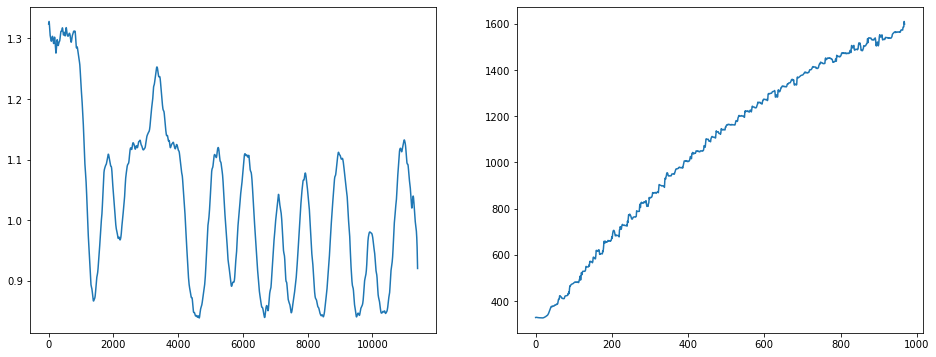

In [18]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res.reference_image[0])
axes[1].plot(st_res.pixel_map[1, 0])
plt.show()

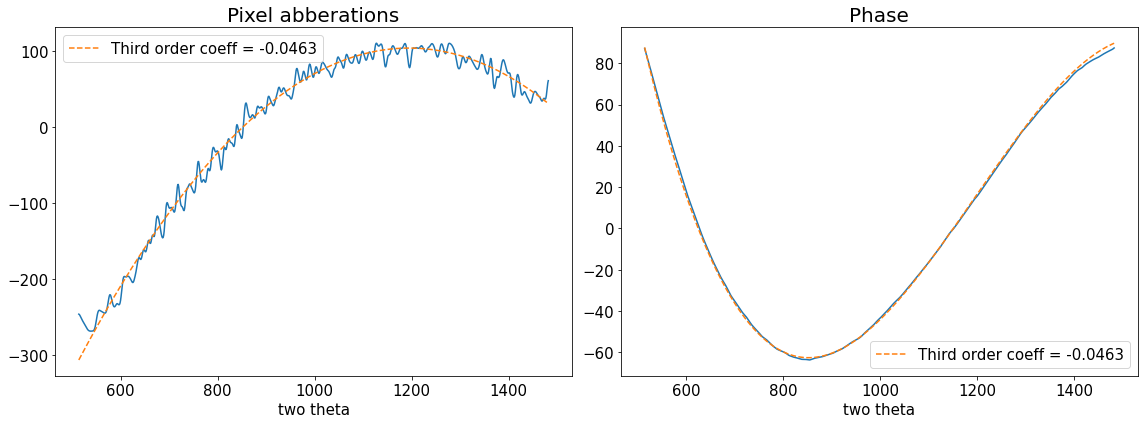

In [19]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fit = fit_obj.fit()
axes[0].plot(fit_obj.pixels, fit_obj.pixel_abberations)
axes[0].plot(fit_obj.pixels, fit_obj.model(fit['fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[0].set_title('Pixel abberations', fontsize=20)
axes[1].plot(fit_obj.pixels, fit_obj.phase)
axes[1].plot(fit_obj.pixels, fit_obj.model(fit['ph_fit']), linestyle='dashed',
             label='Third order coeff = {:.4f}'.format(fit['alpha']))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('two theta', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

# Experiment results

In [34]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1100), 2165: (0, 1, 430, 1140),
            2188: (0, 1, 365, 1155), 2202: (0, 1, 275, 1100), 2274: (0, 1, 430, 1140), 2291: (0, 1, 430, 1140),
            2311: (0, 1, 440, 1220), 2312: (0, 1, 440, 1220), 2313: (0, 1, 430, 1220)}
data_path = 'results/exp/Scan_{:d}.cxi'
scan_num = 2313

loader = rst.loader()
st_data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])
st_data = st_data.make_whitefield()
st_data = st_data.make_pixel_map()

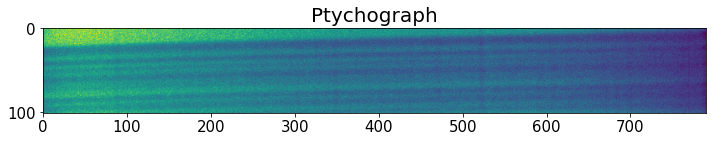

In [35]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(st_data.get('data')[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

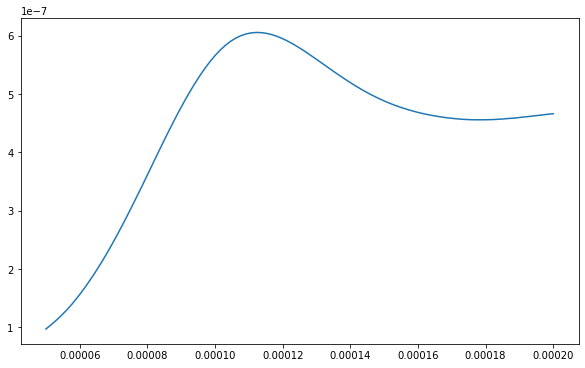

In [67]:
df_arr = np.linspace(5e-5, 2e-4, 100)
ds_scan = st_data.defocus_sweep(df_arr, ls_ri=20)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_arr, ds_scan)
plt.show()

In [68]:
df_fs = df_arr[np.argmax(ds_scan)]
print(df_fs)

0.00011212121212121214


In [65]:
sn_list = [2311, 2312, 2313]
df_list = {2311: 1.1e-4, 2312: 1e-4, 2313: 1e-4}
loader = rst.loader()
data_dict, fit_dict = {}, {}

for scan_num in sn_list:
    st_data = loader.load(data_path.format(scan_num), roi=roi_dict[scan_num])
    st_data = st_data.make_whitefield()
    st_data = st_data.make_pixel_map()

    st_data = st_data.update_defocus(defocus_fs=df_list[scan_num])
    st_obj = st_data.get_st()
    st_res = st_obj.iter_update(sw_fs=100, ls_pm=1.0, ls_ri=5.0, n_iter=5,
                                update_translations=False, return_errors=False)

    data_dict[scan_num] = st_data.update_phase(st_res)
    fit_dict[scan_num] = st_data.get_fit(axis=1)

Iteration No. 0: Total MSE = 0.059
Iteration No. 1: Total MSE = 0.046
Iteration No. 2: Total MSE = 0.044
Iteration No. 3: Total MSE = 0.047
Iteration No. 0: Total MSE = 0.054
Iteration No. 1: Total MSE = 0.049
Iteration No. 2: Total MSE = 0.052
Iteration No. 0: Total MSE = 0.058
Iteration No. 1: Total MSE = 0.051
Iteration No. 2: Total MSE = 0.048
Iteration No. 3: Total MSE = 0.051


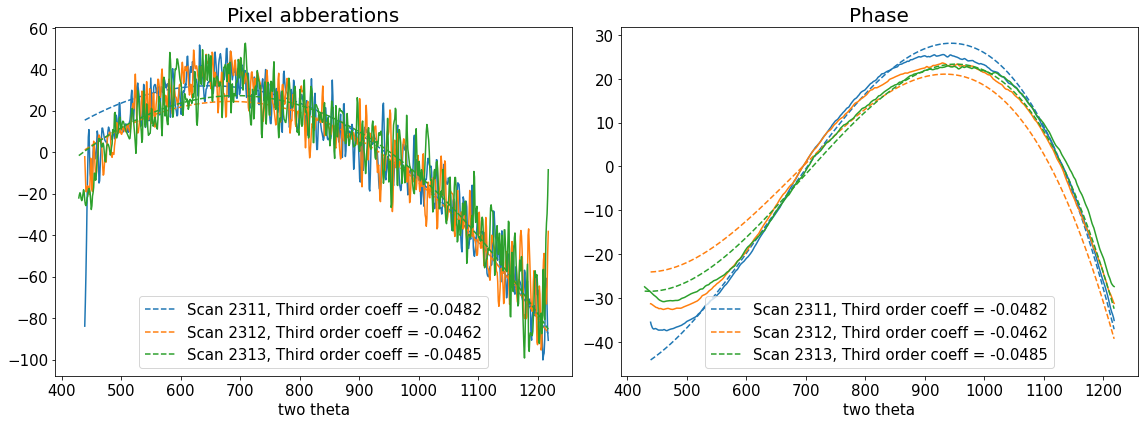

In [66]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for scan_num, color in zip(fit_dict, mcolors.TABLEAU_COLORS.values()):
    fit = fit_dict[scan_num].fit(max_order=2)
    axes[0].plot(fit_dict[scan_num].pixels,
                 fit_dict[scan_num].pixel_abberations, color=color)
    axes[0].plot(fit_dict[scan_num].pixels,
                 fit_dict[scan_num].model(fit['fit']), color=color, linestyle='dashed',
                 label='Scan {:d}, Third order coeff = {:.4f}'.format(scan_num, fit['alpha']))
    axes[0].set_title('Pixel abberations', fontsize=20)
    axes[1].plot(fit_dict[scan_num].pixels,
                 fit_dict[scan_num].phase, color=color)
    axes[1].plot(fit_dict[scan_num].pixels,
                 fit_dict[scan_num].model(fit['ph_fit']), color=color, linestyle='dashed',
                 label='Scan {:d}, Third order coeff = {:.4f}'.format(scan_num, fit['alpha']))
    axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.set_xlabel('two theta', fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('docs/figures/phase_fit.png', dpi=300)

In [26]:
roi_dict = {1511: (0, 1, 340, 1230), 1512: (0, 1, 340, 1230), 1513: (0, 1, 340, 1230), 1595: (0, 1, 360, 1050),
            1596: (0, 1, 360, 1050), 1597: (0, 1, 360, 1050), 1598: (0, 1, 360, 1050), 1654: (0, 1, 360, 1050),
            1670: (0, 1, 300, 1440), 1723: (0, 1, 370, 1195), 1727: (0, 1, 370, 1195), 1738: (0, 1, 350, 1065),
            1739: (0, 1, 350, 1065), 1740: (0, 1, 350, 1065), 1741: (0, 1, 350, 1065), 1856: (0, 1, 330, 1030),
            1857: (0, 1, 330, 1030), 1986: (0, 1, 350, 1200), 2008: (0, 1, 350, 1200)}
filename = 'Scan_{:d}.cxi'
exp_dir = 'results/exp'
scan_num = 2008

with h5py.File(os.path.join(exp_dir, filename.format(scan_num)), 'r') as cxi_file:
    roi = roi_dict[scan_num]
    I_n = cxi_file['/entry_1/data_1/data'][:, roi[0]:roi[1], roi[2]:roi[3]].sum(axis=1)[:, None]
    basis = cxi_file['/entry_1/instrument_1/detector_1/basis_vectors'][...]
    z = cxi_file['/entry_1/instrument_1/detector_1/distance'][...]
    x_ps = cxi_file['/entry_1/instrument_1/detector_1/x_pixel_size'][...]
    y_ps = cxi_file['/entry_1/instrument_1/detector_1/y_pixel_size'][...]
    wl = cxi_file['/entry_1/instrument_1/source_1/wavelength'][...]
    dij = cxi_file['/entry_1/sample_1/geometry/translation'][...]

df = 1e-4
I_n = I_n.astype(np.float64)
M = np.ones((I_n.shape[1], I_n.shape[2]), dtype=bool)
W = make_whitefield(I_n, M)
(dij[1] - dij[0]), I_n.shape[-1], np.mean(I_n), basis[0]

(array([0.0e+00, 9.6e-08, 0.0e+00]),
 850,
 72.90818870122307,
 array([[-5.5e-05,  0.0e+00,  0.0e+00],
        [ 0.0e+00, -5.5e-05,  0.0e+00]]))

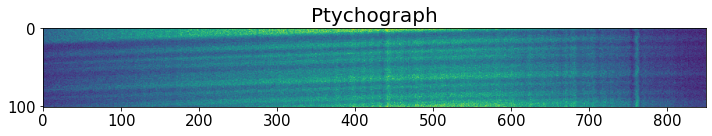

In [27]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(I_n[:, 0])
ax.set_title('Ptychograph', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [73]:
u = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
I0 = make_reference(I_n, W, u, di, dj, ls=20., return_nm0=False)
K = I_n.shape[-1] / (dj[0] - dj[1])
N = I_n.shape[0]
dI0_avg = np.mean(np.gradient(I0[0])**2)
p_var = np.mean(I_n)
u_var = np.sqrt((p_var / N + p_var / N / K) / dI0_avg / np.mean(I_n**2))
print(u_var, K, I_n.shape[-1])
print(dI0_avg)

10.151162106893096 24.348958333599075 850
1.2507496085642653e-06


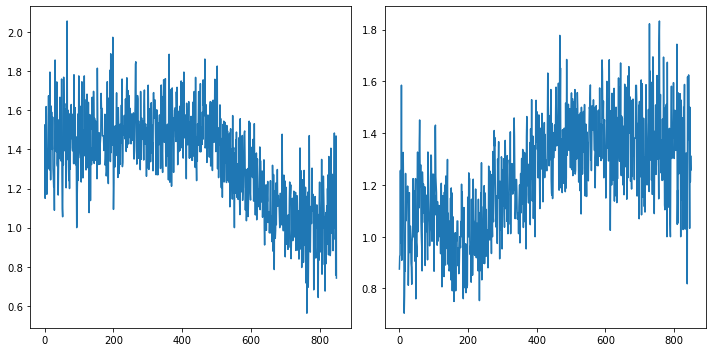

In [74]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(I_n[1, 0] / W[0] )
axes[1].plot(I_n[-1, 0] / W[0])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.show()
# plt.savefig('figures/ptycho.pdf')

In [75]:
#---------------------------
# Intialise
#---------------------------
u0 = np.indices(W.shape, dtype=np.float64)
di, dj = pixel_translations(basis, dij, df, z)
l_scale = 5.5
sw_max = 300

I0, n0, m0 = dev.make_reference(I_n, W, u0, di, dj, ls=l_scale, wfs=0)
I0_avg = dev.make_reference(I_n, W, u0, di, dj, ls=30, wfs=0)[0]
u = dev.upm_search(I_n, W, I0, u0, di - n0, dj - m0, 1, sw_max, l_scale)
# u = dev.upm_newton_1d(I_n, W, I0, u0, di, dj, sw_max, l_scale)
u = u0 + gaussian_filter(u - u0, (0, 0, l_scale))
print(I0.shape)

(1, 4484)


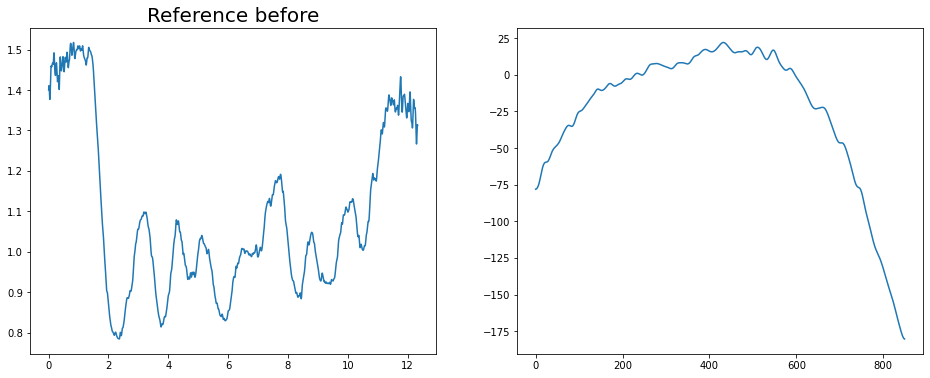

In [76]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(1e6 * np.arange(I0.size) * x_ps * df / z, I0[0])
axes[0].set_title('Reference before', fontsize=20)
axes[1].plot((u - u0)[1, 0])
plt.show()
# plt.savefig('figures/reference_1595.pdf')

In [176]:
st_res = st_update(I_n.astype(np.float32), W, dij, basis, x_ps, y_ps, z, df, u_max=300)
ph_res = phase_fit(st_res['u'], x_ps, z, df, wl, u_var)

updating object map and translations: 4.73e+01:   0%|          | 0/100 [00:00<?, ?it/s]


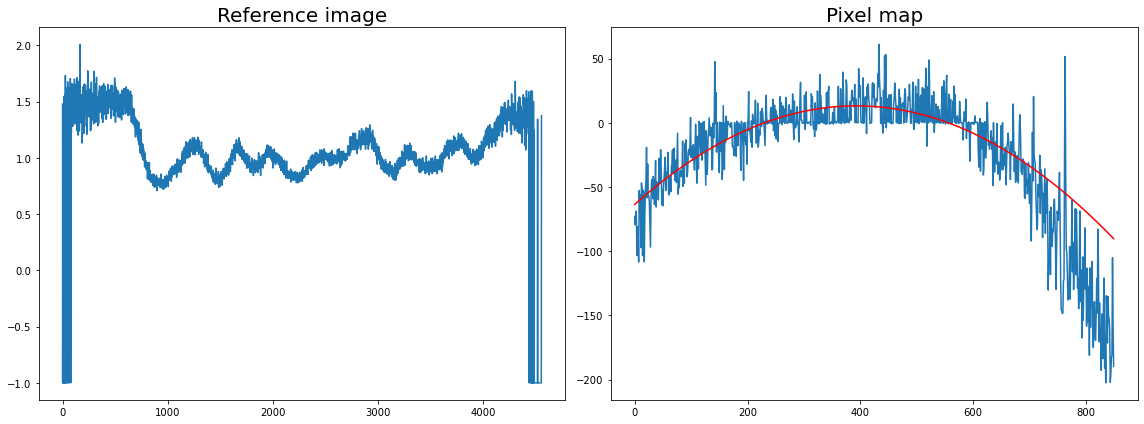

In [159]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(st_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(ph_res['pix'], ph_res['u_pix'])
axes[1].plot(ph_res['pix'], ab_model(ph_res['pix'], ph_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_andrew_1727.pdf')

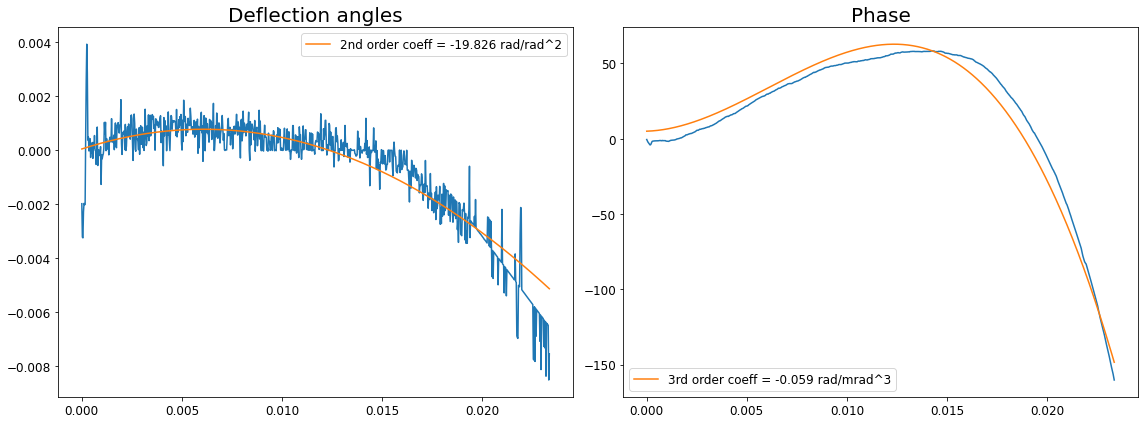

In [359]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(ph_res['theta'], ph_res['angles'])
axes[0].plot(ph_res['theta'], ab_model(ph_res['theta'], ph_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(ph_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(ph_res['theta'], ph_res['phase'])
axes[1].plot(ph_res['theta'], ph_model(ph_res['theta'], ph_res['ph_fit']),
             label='3rd order coeff = {:.3f} rad/mrad^3'.format(ph_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_andrew_1727.pdf')

In [85]:
str_res = str_update(I_n, W, dij, basis, x_ps, y_ps, z, df, u_max=200, l_scale=7., n_iter=5)
phr_res = phase_fit(str_res['u'], x_ps, z, df, wl, u_var)

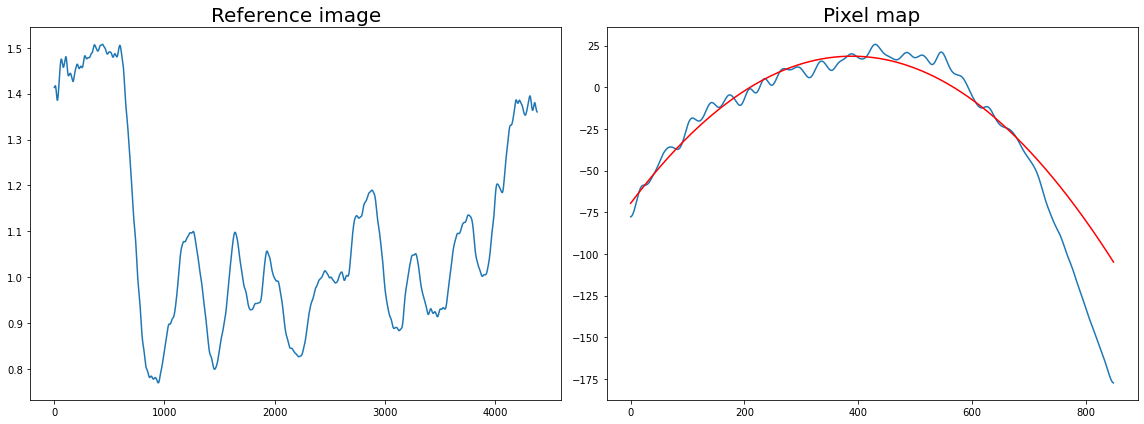

In [86]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(str_res['I0'][0])
axes[0].set_title('Reference image', fontsize=20)
axes[1].plot(phr_res['pix'], phr_res['u_pix'])
axes[1].plot(phr_res['pix'], ab_model(phr_res['pix'], phr_res['fit'].x), color='red')
axes[1].set_title('Pixel map', fontsize=20)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_results_robust_1896.pdf')

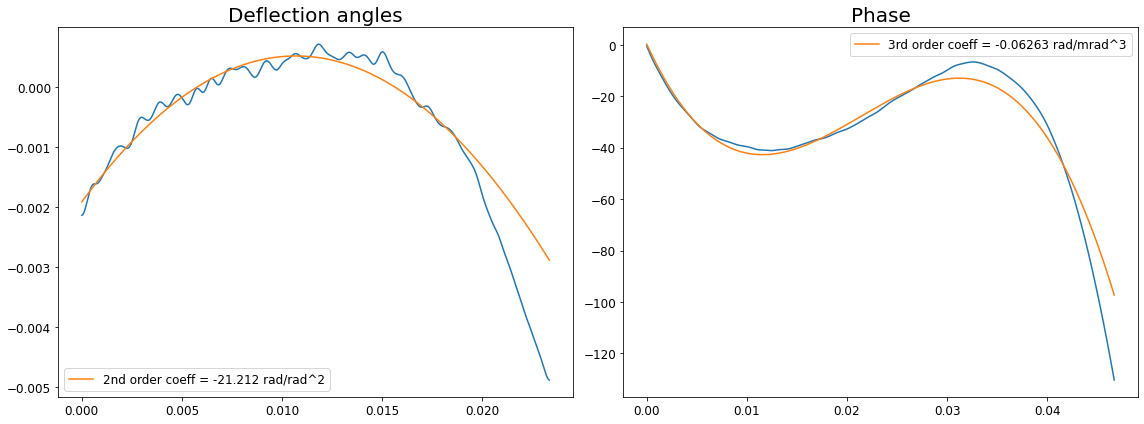

In [87]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(phr_res['theta'], phr_res['angles'])
axes[0].plot(phr_res['theta'], ab_model(phr_res['theta'], phr_res['ang_fit']),
             label='2nd order coeff = {:.3f} rad/rad^2'.format(phr_res['ang_fit'][2]))
axes[0].set_title('Deflection angles', fontsize=20)
axes[1].plot(2 * phr_res['theta'], phr_res['phase'])
axes[1].plot(2 * phr_res['theta'], ph_model(phr_res['theta'], phr_res['ph_fit']),
             label='3rd order coeff = {:.5f} rad/mrad^3'.format(phr_res['ph_fit'][3] * 1e-9))
axes[1].set_title('Phase', fontsize=20)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)
plt.tight_layout()
plt.show()
# plt.savefig('figures/st_fits_robust_1896.pdf')